In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import time
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from transformers import BertTokenizerFast, AutoModel, AdamW
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from transformers import DistilBertModel, DistilBertTokenizerFast
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import BertModel, BertConfig,BertTokenizerFast
import numpy as np

In [2]:
DATA_PATH = "data"
train_df = pd.read_json(DATA_PATH+"/train.json")
test_df = pd.read_json(DATA_PATH+"/test.json")
train_label = pd.read_csv(DATA_PATH+"/train_label.csv")
cate = pd.read_csv(DATA_PATH+"/categories_string.csv")

In [3]:
train_df = train_df.merge(train_label,on='Id',how='left')

In [4]:
cate

,0,1
0,pastor,0
1,model,1
2,yoga_teacher,2
3,teacher,3
4,personal_trainer,4
5,painter,5
6,journalist,6
7,interior_designer,7
8,surgeon,8
9,accountant,9


In [5]:
train_df['Category'].value_counts().sort_values(ascending=True)

21      783
4       807
10      831
7       858
2       944
23      967
17     1406
0      1497
12     1639
27     2288
9      3121
25     3395
13     4060
1      4115
18     4124
15     4292
5      4621
16     5450
24     5841
8      6616
3      9145
22    10391
11    11607
6     12295
14    12622
20    14646
26    18820
19    70016
Name: Category, dtype: int64

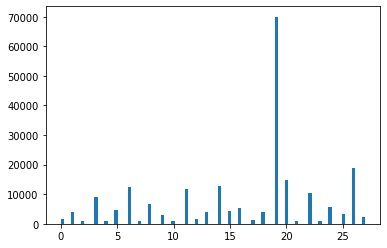

In [6]:
plt.hist(train_label['Category'],bins='auto');

In [10]:
train_df['description'].iloc[0]

' She is also a Ronald D. Asmus Policy Entrepreneur Fellow with the German Marshall Fund and is a Visiting Fellow at the Centre for International Studies (CIS) at the University of Oxford. This commentary first appeared at Sada, an online journal published by the Carnegie Endowment for International Peace.'

In [8]:
train_df.groupby('Category')['gender'].value_counts()

Category  gender
0         M          1137
          F           360
1         F          3398
          M           717
2         F           803
          M           141
3         F          5420
          M          3725
4         M           443
          F           364
5         M          2490
          F          2131
6         M          6172
          F          6123
7         F           694
          M           164
8         M          5726
          F           890
9         M          1992
          F          1129
10        M           706
          F           125
11        M          7026
          F          4581
12        M          1294
          F           345
13        M          3447
          F           613
14        F         11493
          M          1129
15        F          2153
          M          2139
16        M          3555
          F          1895
17        M          1015
          F           391
18        M          2730
          F          

In [3]:
import nltk
import re





In [4]:
train_df['description'] = train_df['description'].apply(lambda x: re.sub(r"[^a-zA-Z]+", ' ', x))
from nltk.tokenize import word_tokenize
train_df['description'] = train_df['description'].apply(lambda x : word_tokenize(x.lower()))

KeyboardInterrupt: 

In [5]:
train_df['description']

0         [she, is, also, a, ronald, d, asmus, policy, e...
1         [he, is, a, member, of, the, aicpa, and, wicpa...
2         [dr, aster, has, held, teaching, and, research...
4         [he, runs, a, boutique, design, studio, attend...
5         [he, focuses, on, cloud, security, identity, a...
                                ...                        
271492    [a, member, of, the, uwa, cultural, collection...
271493    [kelly, has, worked, globally, leading, teams,...
271494    [he, s, the, lead, author, of, a, recent, stud...
271495    [she, specializes, in, the, theoretical, and, ...
271496    [since, she, was, years, old, she, has, become...
Name: description, Length: 217197, dtype: object

In [6]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train_df['potential'] = train_df['description'].apply(lambda x: [item for item in x if item not in stop])

In [7]:
train_df['potential'].iloc[1]

['member',
 'aicpa',
 'wicpa',
 'brent',
 'graduated',
 'university',
 'wisconsin',
 'la',
 'crosse',
 'degree',
 'accountancy',
 'lived',
 'southern',
 'wisconsin',
 'entire',
 'life',
 'currently',
 'resides',
 'pardeeville',
 'wife',
 'sara',
 'three',
 'children',
 'brent',
 'sara',
 'great',
 'appreciation',
 'music',
 'art',
 'theater']

In [8]:
train = train_df.merge(train_label,on='Id',how='left')
train['potential']=train['potential'].apply(lambda row : ' '.join(row))



In [9]:
train['potential'][217190]

'obtained bachelor commerce college commerce gadag master degree business administration rajrambapu institute technology islampur ph university pune pune maharashtra india guiding ph students visvesvaraya technological university belagavi karnataka guided u g pg students conducted conferences workshops fdp pdp published papers national journals papers international journals'

In [10]:
train['merge']= train.groupby('Category')['potential'].transform(lambda x: ' '.join(' '+x+' '))

In [11]:
tmp = train.groupby('Category').first().reset_index()
dist = tmp[['merge','Category']]


In [12]:
from collections import Counter
dist['merge'] = dist['merge'].apply(lambda x : word_tokenize(x))
clss_dict = [dict(Counter(dist['merge'][cls]).most_common()) for cls in range (28)]

/home/adil/anaconda3/envs/ma-gym/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
dist['merge'][25][300:400]

['access',
 'hollywood',
 'nbc',
 'best',
 'damn',
 'sports',
 'espn',
 'amc',
 'various',
 'promos',
 'espn',
 'various',
 'promos',
 'travis',
 'pastrana',
 'history',
 'espn',
 'music',
 'used',
 'work',
 'wayne',
 'mcgregor',
 'jane',
 'mason',
 'jasmin',
 'vardimon',
 'cathy',
 'marston',
 'retina',
 'dance',
 'company',
 'tinderbox',
 'theatre',
 'company',
 'box',
 'clever',
 'film',
 'music',
 'includes',
 'colourkeys',
 'director',
 'dave',
 'daniels',
 'tandem',
 'films',
 'dance',
 'lexie',
 'dance',
 'director',
 'tim',
 'loane',
 'cluck',
 'director',
 'terry',
 'loane',
 'session',
 'piano',
 'player',
 'songwriter',
 'producer',
 'worked',
 'jacqui',
 'dankworth',
 'foy',
 'vance',
 'ken',
 'haddock',
 'brian',
 'houston',
 'u',
 'f',
 'f',
 'ghears',
 'iain',
 'archer',
 'songlines',
 'project',
 'currently',
 'seeking',
 'volunteer',
 'singers',
 'recently',
 'pioneered',
 'red',
 'room',
 'sessions',
 'series',
 'intimate',
 'concerts',
 'belfast',
 'released',
 'albu

In [33]:
print(clss_dict[0].keys())

dict_keys(['church', 'years', 'pastor', 'ministry', 'also', 'god', 'university', 'children', 'seminary', 'wife', 'christian', 'theological', 'served', 'two', 'people', 'life', 'time', 'college', 'new', 'school', 'bible', 'christ', 'one', 'married', 'theology', 'family', 'currently', 'com', 'faith', 'churches', 'book', 'author', 'three', 'books', 'work', 'jesus', 'degree', 'since', 'first', 'husband', 'lives', 'community', 'women', 'ministries', 'director', 'world', 'youth', 'graduate', 'serves', 'well', 'music', 'worship', 'baptist', 'education', 'live', 'many', 'leadership', 'loves', 'passion', 'writing', 'www', 'four', 'studies', 'several', 'serving', 'preaching', 'lutheran', 'biblical', 'home', 'received', 'divinity', 'master', 'year', 'member', 'pastors', 'love', 'published', 'united', 'including', 'young', 'congregation', 'teaching', 'blog', 'working', 'local', 'board', 'co', 'state', 'spiritual', 'word', 'part', 'holds', 'mission', 'enjoys', 'father', 'hope', 'president', 'others

In [31]:
all_words = []
for cls in range (28):
    #all_words += list(clss_dict[cls].keys())
    print(list(clss_dict[cls].keys()))
    break

['church', 'years', 'pastor', 'ministry', 'also', 'god', 'university', 'children', 'seminary', 'wife', 'christian', 'theological', 'served', 'two', 'people', 'life', 'time', 'college', 'new', 'school', 'bible', 'christ', 'one', 'married', 'theology', 'family', 'currently', 'com', 'faith', 'churches', 'book', 'author', 'three', 'books', 'work', 'jesus', 'degree', 'since', 'first', 'husband', 'lives', 'community', 'women', 'ministries', 'director', 'world', 'youth', 'graduate', 'serves', 'well', 'music', 'worship', 'baptist', 'education', 'live', 'many', 'leadership', 'loves', 'passion', 'writing', 'www', 'four', 'studies', 'several', 'serving', 'preaching', 'lutheran', 'biblical', 'home', 'received', 'divinity', 'master', 'year', 'member', 'pastors', 'love', 'published', 'united', 'including', 'young', 'congregation', 'teaching', 'blog', 'working', 'local', 'board', 'co', 'state', 'spiritual', 'word', 'part', 'holds', 'mission', 'enjoys', 'father', 'hope', 'president', 'others', 'traini

In [28]:
str(clss_dict[cls].keys())

"dict_keys(['nutrition', 'health', 'university', 'food', 'years', 'medical', 'dietitian', 'weight', 'hospital', 'also', 'science', 'healthy', 'degree', 'eating', 'diet', 'professional', 'graduated', 'information', 'dietetics', 'registered', 'book', 'dietetic', 'completed', 'management', 'clinical', 'experiences', 'center', 'diverse', 'wellness', 'doctors', 'number', 'especially', 'appointment', 'honors', 'call', 'phone', 'clients', 'specialists', 'nutritional', 'affiliates', 'education', 'cooperates', 'advises', 'bachelor', 'working', 'diabetes', 'new', 'group', 'worked', 'practice', 'master', 'experience', 'patients', 'counseling', 'program', 'internship', 'well', 'care', 'lifestyle', 'com', 'research', 'people', 'disease', 'works', 'currently', 'loss', 'state', 'sports', 'college', 'including', 'received', 'member', 'community', 'children', 'groups', 'public', 'life', 'services', 'association', 'foods', 'helping', 'help', 'time', 'medicine', 'private', 'school', 'training', 'based', 

In [26]:
all_words = set(all_words)

In [9]:
for cls in range (28):
    for key in list(all_words):
        if key not in clss_dict[cls]:
            clss_dict[cls][key] = 0
            

In [27]:
all_words

{' ',
 "'",
 '(',
 ')',
 ',',
 '[',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [7]:
len(clss_dict[0])

11068

In [11]:
res = []
for cls in range (28):
    res.append(pd.DataFrame(list(clss_dict[0].items()),columns=['word','proba']))


In [15]:
res[0].sort_values(by=['word']).head(50)

,word,proba
8878,aa,1
100344,aaa,0
94727,aaaa,0
328162,aaaahc,0
55246,aaaai,0
351724,aaaajreceived,0
75240,aaaasf,0
23999,aaacd,0
317392,aaae,0
53414,aaai,0


In [35]:
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
for synset in wn.synsets(''):
    for lemma in synset.lemmas():
        print(lemma.name())

professor
prof


[nltk_data] Downloading package wordnet to /home/adil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
k=0

In [22]:
k = np.random.randint(train_df.shape[0])
print(train_df['description'].iloc[k])
print(train_label['Category'].iloc[k])

 He provides individual, family, and group therapy to children, adolescents, and adults through his private practice. Dr. Sheppard supervises clinical staff and graduate students in both Kentucky and Indiana. Group Psychotherapy with Children, a training curriculum authored by Dr. Sheppard, was published in 2008 by the American Group Psychotherapy Association (AGPA). This organization honored Dr. Sheppard in 2012 by naming him a Fellow (FAGPA). Dr. Sheppard teaches in the School of Professional Psychology at Spalding University and teaches, presents, and lectures at the local, state, and national levels.
22


In [3]:
train, val, train_labels, val_labels = train_test_split(train_df,train_label['Category'],test_size=0.2,stratify=train_label['Category'])

In [4]:
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# train_encoding = tokenizer.batch_encode_plus(train['description'].to_list(),max_length = 170\
#                                              ,padding=True,truncation=True)
# val_encoding = tokenizer.batch_encode_plus(val['description'].to_list(),max_length = 170\
#                                              ,padding=True,truncation=True)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_encoding = tokenizer.batch_encode_plus(train['description'].to_list(),max_length = 170\
                                              ,padding=True,truncation=True)
val_encoding = tokenizer.batch_encode_plus(val['description'].to_list(),max_length = 170\
                                              ,padding=True,truncation=True)

In [5]:
class NlpTrainDataset(Dataset):
    def __init__(self,Id,labels,encodings):
        self.labels = labels.tolist()
        self.encodings = encodings
        self.Id  = Id.to_list()

    def __getitem__(self,idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['Id'] = self.Id[idx]
        return item

    def __len__(self):
        return len(self.labels)

    

<AxesSubplot:>

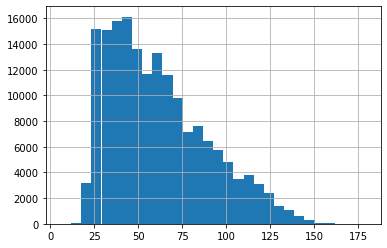

In [6]:
seq_len = [len(i.split()) for i in train['description']]

pd.Series(seq_len).hist(bins = 30)

In [7]:
train_dataset = NlpTrainDataset(train['Id'],train_labels,train_encoding)
val_dataset = NlpTrainDataset(val['Id'],val_labels,val_encoding)

In [8]:
len(val_dataset)

43440

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True,num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True,num_workers=8)

In [10]:
class BertClf(nn.Module):

    def __init__(self, bert):

        super(BertClf, self).__init__()

        self.bert = bert 
        self.dropout1 = nn.Dropout(0.6)
        self.dropout2 = nn.Dropout(0.1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu =  nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,28)
#         self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

        #pass the inputs to the model
#         _, cls_hs = self.bert(sent_id, attention_mask=mask)
#         cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0] distil
        _,cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)
#         x = self.bn1(x)
#         x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu(x)
#         x = self.bn2(x)
#         x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.relu(x)
#         x = self.bn3(x)
#         x = self.dropout2(x)
        
        x = self.fc4(x)
        x = self.relu(x)
#         x = self.softmax(x)

        return x

In [11]:
bert = AutoModel.from_pretrained('bert-base-uncased')
# configuration = BertConfig()
# model = BertModel(configuration)
for param in bert.parameters():
    param.requires_grad = False

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
# my_list = ['fc1.weight','fc1.bias','fc2.weight','fc2.bias',\
#            'fc3.weight','fc3.bias','fc4.weight','fc4.bias',\
#           'bn1.weight','bn1.bias','bn2.weight','bn2.bias','bn3.weight','bn3.bias']
# params = list(filter(lambda kv: kv[0] in my_list, model.named_parameters()))
# base_params = list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))

In [14]:
model = BertClf(bert)
model = model.to(device)
# optimizer = AdamW([{'params': model.bert.parameters(),'lr':1e-5, 'weight_decay':0.02}],lr=1e-3)
optimizer = AdamW(model.parameters(),lr = 1e-4)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

In [15]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels.values)

print("Class Weights:",class_weights)

Class Weights: [5.17997257 1.88505685 8.21934721 0.84822405 9.60620301 1.67855211
 0.6309076  9.04607455 1.17241775 2.48522513 9.33174006 0.66834757
 4.73349134 1.91059333 0.6145991  1.80763389 1.42330439 5.51609524
 1.88105703 0.11078869 0.52962423 9.91311045 0.7464943  8.01758029
 1.32797071 2.28483326 0.41216838 3.39104215]


In [16]:

# push to GPU
weights = weights.to(device)        




# number of training epochs
epochs = 50

In [17]:
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]
    total_labels = []

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
#         for key,value in batch.items():
#             batch[key] = batch[key].to(device)
            
        sent_id = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()
        
        

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        
        labels = labels.detach().cpu().numpy().tolist()
        
        # append the model predictions
        total_preds.append(preds)
        
        total_labels+= labels
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds, total_labels

In [18]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        sent_id = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)
            
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            
            labels = labels.detach().cpu().numpy().tolist()
            

            total_preds.append(preds)
            total_labels+=labels
            
            
            

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds, total_labels

In [19]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_pred, train_lab = train()
    
    #evaluate model
    valid_loss, val_pred, val_lab = evaluate()
    
    
    res_train = np.argmax(train_pred,axis=1).tolist()
    res_val = np.argmax(val_pred,axis=1).tolist()
    
    f1_train = f1_score(train_lab, res_train,average='macro')
    f1_val = f1_score(val_lab, res_val,average='macro')
    
    #save the best model
    
#     scheduler.step()
    torch.save(model.state_dict(), f'models/saved_weights_{epoch}_train_{train_loss:.3f}_valid_{valid_loss:.3f}.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    
    
    print(f'\nTraining Loss: {train_loss:.3f}, Training f1 : {f1_train}')
    print(f'Validation Loss: {valid_loss:.3f}, Validation f1 : {f1_val}')


 Epoch 1 / 50
  Batch    50  of  1,358.
  Batch   100  of  1,358.
  Batch   150  of  1,358.
  Batch   200  of  1,358.
  Batch   250  of  1,358.
  Batch   300  of  1,358.
  Batch   350  of  1,358.
  Batch   400  of  1,358.
  Batch   450  of  1,358.
  Batch   500  of  1,358.
  Batch   550  of  1,358.
  Batch   600  of  1,358.
  Batch   650  of  1,358.
  Batch   700  of  1,358.
  Batch   750  of  1,358.
  Batch   800  of  1,358.
  Batch   850  of  1,358.
  Batch   900  of  1,358.
  Batch   950  of  1,358.
  Batch 1,000  of  1,358.
  Batch 1,050  of  1,358.
  Batch 1,100  of  1,358.
  Batch 1,150  of  1,358.
  Batch 1,200  of  1,358.
  Batch 1,250  of  1,358.
  Batch 1,300  of  1,358.
  Batch 1,350  of  1,358.

Evaluating...
  Batch    50  of    340.
  Batch   100  of    340.
  Batch   150  of    340.
  Batch   200  of    340.
  Batch   250  of    340.
  Batch   300  of    340.

Training Loss: 3.010, Training f1 : 0.12193084409610958
Validation Loss: 2.763, Validation f1 : 0.2155109186213

KeyboardInterrupt: 

In [ ]:
plt.plot(valid_losses)
plt.plot(train_losses)

In [ ]:
#load weights of best model
path = 'models/saved_weights_0_train_2.459_valid_1.417.pt'
model.load_state_dict(torch.load(path))

In [ ]:
class NlpTrainDataset(Dataset):
    def __init__(self,encodings):
        self.encodings = encodings

    def __getitem__(self,idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return {'input_ids' : item['input_ids'].to(device), 'attention_mask' : item['attention_mask'].to(device)}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
sent_id = val_encoding['input_ids']
mask = val_encoding['attention_mask']

In [ ]:
testdata = NlpTrainDataset(val_encoding)
val_dataloader = DataLoader(testdata, batch_size=1)

In [ ]:
total_preds = []
for batch in tqdm(val_dataloader):
    preds = model(batch['input_ids'], batch['attention_mask'])
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)
    del preds
    

In [ ]:
preds = [np.exp(pred) for pred in total_preds]
preds = [np.argmax(pred) for pred in total_preds]

In [26]:
f1_score(val_labels.to_list(), preds,average='macro')

0.4257129975680609

In [25]:
test_encoding = tokenizer.batch_encode_plus(test_df['description'].to_list(),max_length = 170\
                                             ,padding=True,truncation=True)

In [26]:
testdata = NlpTrainDataset(test_encoding)
test_dataloader = DataLoader(testdata, batch_size=1)

In [27]:
total_preds = []
for batch in tqdm(test_dataloader):
    preds = model(batch['input_ids'], batch['attention_mask'])
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)
    del preds

  0%|          | 0/54300 [00:00<?, ?it/s]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

In [30]:
preds = [np.exp(pred) for pred in total_preds]
preds = [np.argmax(pred) for pred in total_preds]

In [31]:
submission = pd.DataFrame()

In [32]:
submission['Id'] = test_df['Id']
submission['Category'] = preds

In [33]:
submission.to_csv('random_soum.csv',index=False)